In [91]:
import json
import re

# data paths of coco styled json annotations file
data_path = '/media/baudoin/SSDUbuntu/data/UAV123'
coco_annotations_path = '/annotations/uav123.json'

# open json
anno_file = open(data_path + coco_annotations_path, "r")
anno_json = json.load(anno_file)
anno_file.close()

# Define labels _file.of UAV123 dataset
labels = {'bike':1, 'bird':2, 'boat':3, 'building':4, 'car':5 , 'group':6, 'person':7, 'truck':8, 'uav':9, 'wakeboard':10}
labels_cond = ''
for label in list(labels.keys()):
    labels_cond += label + '|' 
labels_cond = labels_cond[:-1]

# Extract info of json file and write in a csv file
with open(data_path + '/annotations/retina_anno.csv', 'a') as csv_file:
    for anno, img in zip(anno_json['annotations'],anno_json['images']):
        
        if (anno['bbox'][0] == 0) and (anno['bbox'][1]==0):
            new_coordinates = ['']*4
            label = ''
        else:
            new_coordinates = [x + y for (x, y) in zip(anno['bbox'] , [0,0, anno['bbox'][0], anno['bbox'][1]])]
            label = re.findall(labels_cond, img['file_name'])[0]
        img_path = data_path + '/data_seq/UAV123/' + img['file_name']
        csv_file.write(img_path + ',' + ','.join([str(i) for i in new_coordinates]) + ',' + label + '\n')

# Labels file
with open(data_path + '/annotations/class_labels.csv', 'a') as csv_file:
    for name, id in zip(labels.keys(), labels.values()):
        csv_file.write(name + ',' + str(id) + '\n')
    


# Calculation of bbox sizes and corresponding ratio to the size of the tile for Visdrone

In [43]:
from retinanet.dataloader import CocoDataset, CSVDataset, collater, Resizer, AspectRatioBasedSampler, Augmenter, UnNormalizer, Normalizer
from torchvision import datasets, models, transforms
from retinanet.csv_eval import _get_annotations, compute_overlap, _compute_ap
import numpy as np

classes_path = '/home/baudoin/pytorch-retinanet-pipeline/annotations/visdrone_anno/class_labels.csv'
pred_anno = '/home/baudoin/pytorch-retinanet-pipeline/annotations/visdrone_anno/tiles_multi_anno_val.csv'#154.csv'
gt_anno  = '/home/baudoin/pytorch-retinanet-pipeline/annotations/visdrone_anno/annotations_val.csv'#'/home/baudoin/data/zurich_data/annotated_images/retina_anno.csv' # ##img_154_anno.csv'

gt_data = CSVDataset(train_file=gt_anno, class_list=classes_path,
                        transform=transforms.Compose([Normalizer(), Resizer()]))
gt, gt_img_names = _get_annotations(gt_data, return_img_names=True)

pred_data = CSVDataset(train_file=pred_anno, class_list=classes_path, transform=transforms.Compose([Normalizer(), Resizer()]), read_score=True)
pred, pred_img_names = _get_annotations(pred_data, return_img_names=True)

def avg_bbox_size(pred_data, pred):
    mean_width = []
    mean_height = []
    mean_p = []
    std_width = []
    std_height = []
    std_p = []
    width = []
    height = []
    p = []
    for label in range(pred_data.num_classes()):
        for i in range(len(pred_data)):
            w = pred[i][label][:,2] - pred[i][label][:,0]
            h = pred[i][label][:,3] - pred[i][label][:,1]
            width.append(w)
            height.append(h)
            p.append([w[i]*h[i] for i in range(len(w))])


        mean_width.append(np.mean([item for sublist in width for item in sublist]))
        mean_height.append(np.mean([item for sublist in height for item in sublist]))
        mean_p.append(np.mean([item for sublist in p for item in sublist]))
        std_width.append(np.std([item for sublist in width for item in sublist]))
        std_height.append(np.std([item for sublist in height for item in sublist]))
        std_p.append(np.std([item for sublist in p for item in sublist]))
            #detections = np.mean(pred[i][label], axis = 0)
    return mean_width, mean_height, std_width, std_height, mean_p, std_p

mean_width, mean_height, std_width, std_height, mean_area, std_area = avg_bbox_size(pred_data, pred)

In [44]:
mean_area

[525.5405834340992,
 497.7245104519541,
 549.7089183480364,
 780.9234958788714,
 877.5934524647062,
 961.1215464225813,
 984.0751937007874,
 984.0751937007874,
 1021.3510359862327,
 1003.8883634213996]

<ErrorbarContainer object of 3 artists>

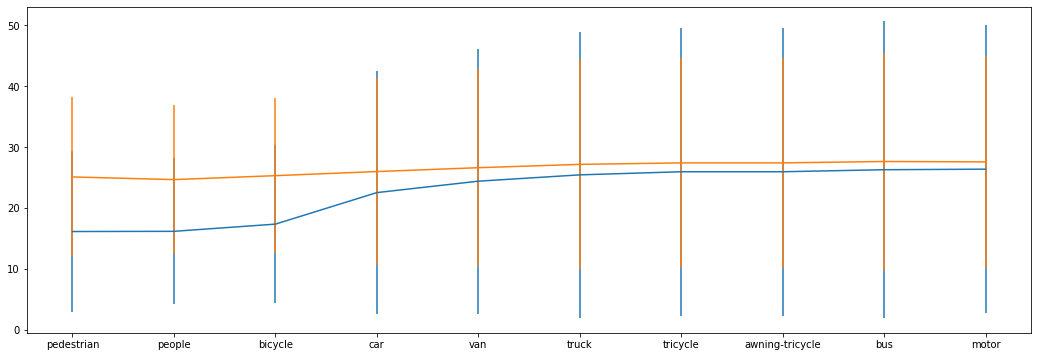

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18,6))
#plt.plot([pred_data.label_to_name(i) for i in range(10)], mean_width)
plt.errorbar([pred_data.label_to_name(i) for i in range(10)], mean_width, std_width)
plt.errorbar([pred_data.label_to_name(i) for i in range(10)], mean_height, std_height)


<ErrorbarContainer object of 3 artists>

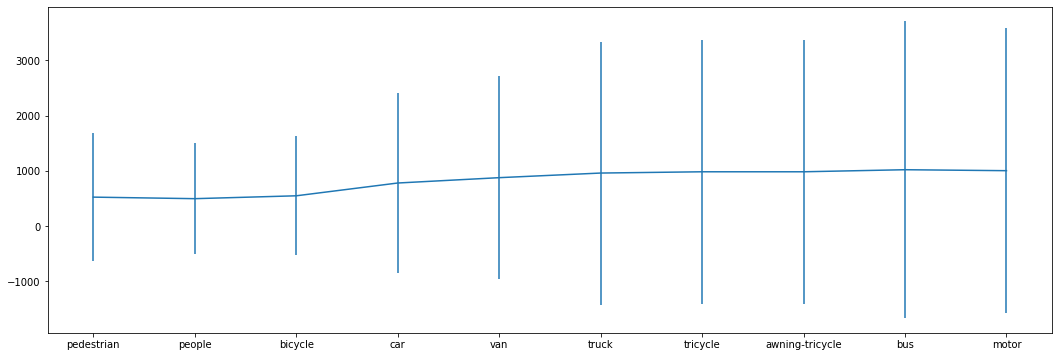

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18,6))
plt.errorbar([pred_data.label_to_name(i) for i in range(10)], mean_area, std_area)


Text(0.5, 1.0, 'Ratio mean area / resolution used to maximize detection mAP score')

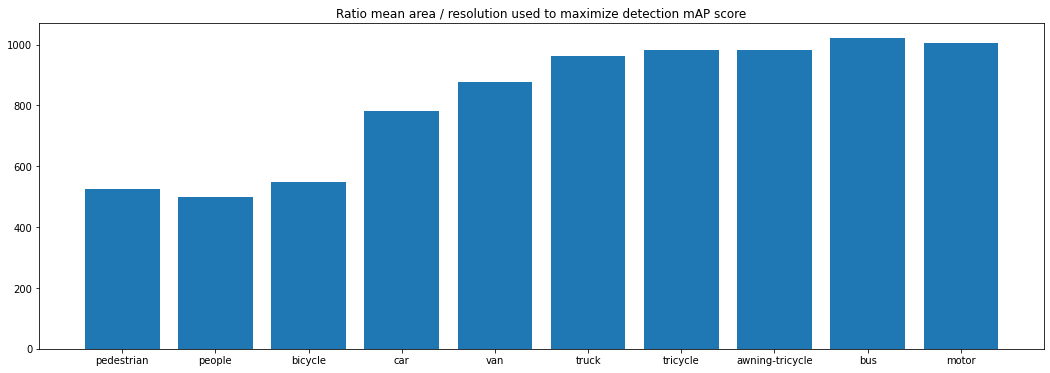

In [35]:
resolution = {'pedestrian':400,
 'people':400,
 'bicycle':800,
 'car':400,
 'van':600,
 'truck':800,
 'tricycle':800,
 'awning-tricycle':400,
 'bus':800,
 'motor':800}

ratios = [mean_area[i] / list(resolution.values())[i]*list(resolution.values())[i] for i in range(len(mean_area))]

plt.figure(figsize=(18,6))
plt.bar([pred_data.label_to_name(i) for i in range(10)], ratios)
plt.title('Ratio mean area / resolution used to maximize detection mAP score')

# for Zurich

In [45]:
from retinanet.dataloader import CocoDataset, CSVDataset, collater, Resizer, AspectRatioBasedSampler, Augmenter, UnNormalizer, Normalizer
from torchvision import datasets, models, transforms
from retinanet.csv_eval import _get_annotations, compute_overlap, _compute_ap
import numpy as np

classes_path = '/home/baudoin/pytorch-retinanet-pipeline/annotations/visdrone_anno/class_labels.csv'
output_annotation_file = '/home/baudoin/pytorch-retinanet-pipeline/annotations/zurich_anno/anno.csv'#154.csv'
gt_annotations_file  = '/home/baudoin/pytorch-retinanet-pipeline/annotations/zurich_anno/original_anno.csv'#'/home/baudoin/data/zurich_data/annotated_images/retina_anno.csv' # ##img_154_anno.csv'

gt_data = CSVDataset(train_file=gt_anno, class_list=classes_path,
                        transform=transforms.Compose([Normalizer(), Resizer()]))
gt, gt_img_names = _get_annotations(gt_data, return_img_names=True)

pred_data = CSVDataset(train_file=pred_anno, class_list=classes_path, transform=transforms.Compose([Normalizer(), Resizer()]), read_score=True)
pred, pred_img_names = _get_annotations(pred_data, return_img_names=True)

def avg_bbox_size(pred_data, pred):
    mean_width = []
    mean_height = []
    mean_p = []
    std_width = []
    std_height = []
    std_p = []
    width = []
    height = []
    p = []
    for label in range(pred_data.num_classes()):
        for i in range(len(pred_data)):
            w = pred[i][label][:,2] - pred[i][label][:,0]
            h = pred[i][label][:,3] - pred[i][label][:,1]
            width.append(w)
            height.append(h)
            p.append([w[i]*h[i] for i in range(len(w))])


        mean_width.append(np.mean([item for sublist in width for item in sublist]))
        mean_height.append(np.mean([item for sublist in height for item in sublist]))
        mean_p.append(np.mean([item for sublist in p for item in sublist]))
        std_width.append(np.std([item for sublist in width for item in sublist]))
        std_height.append(np.std([item for sublist in height for item in sublist]))
        std_p.append(np.std([item for sublist in p for item in sublist]))
            #detections = np.mean(pred[i][label], axis = 0)
    return mean_width, mean_height, std_width, std_height, mean_p, std_p

mean_width, mean_height, std_width, std_height, mean_area, std_area = avg_bbox_size(gt_data, gt)

<ErrorbarContainer object of 3 artists>

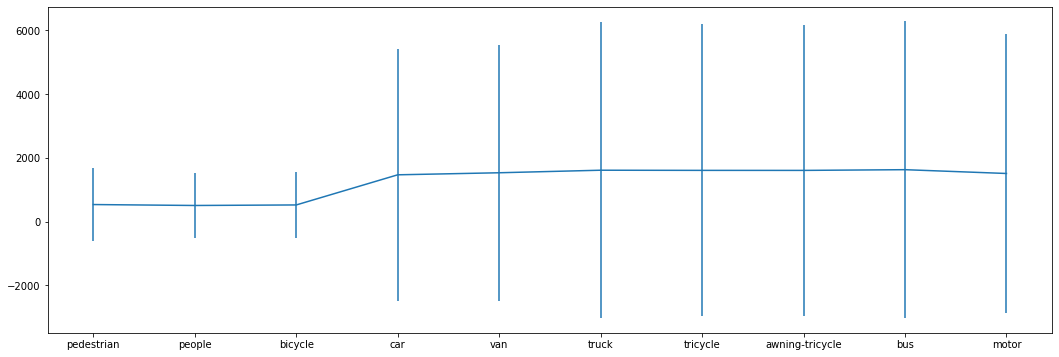

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18,6))
plt.errorbar([pred_data.label_to_name(i) for i in range(10)], mean_area, std_area)


In [50]:

tile_ratio = np.array(mean_area) / np.array(ratios)
tile_resolution = np.array(list(resolution.values())) * np.sqrt(tile_ratio)

for i in range(len(tile_resolution)):
    print(gt_data.label_to_name(i), tile_resolution[i])


pedestrian 404.6712984825919
people 404.3371524602973
bicycle 782.1131124995013
car 548.9083780513502
van 793.4781714769764
truck 1036.9449929601878
tricycle 1023.2187448256465
awning-tricycle 511.47471879275923
bus 1011.1068860420577
motor 981.8448228169166


In [41]:
window_sizes = {400: ['pedestrian', 'people'], 600: ['car', 'motor', 'awning-tricycle'], 800: ['truck', 'bus', 'bicycle','van'], 1000:['tricycle', 'bus', 'motor']}


[525.5405834340992,
 497.7245104519541,
 549.7089183480364,
 780.9234958788714,
 877.5934524647062,
 961.1215464225813,
 984.0751937007873,
 984.0751937007873,
 1021.3510359862325,
 1003.8883634213995]

In [42]:
mean_area

[537.8870420624152,
 508.5765623881452,
 525.4022679601468,
 1470.5785470668486,
 1534.831985940246,
 1614.766671867686,
 1609.8495315805378,
 1609.0022306822914,
 1631.5079561892953,
 1512.1370520395262]

# Superpoint Eval

In [1]:
import numpy as np
import torchvision
import os

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
from tqdm import tqdm

from retinanet.networks.superpoint_pytorch import SuperPointFrontend


from retinanet.dataloader import CocoDataset, CSVDataset, collater, Resizer, AspectRatioBasedSampler, Augmenter, \
	UnNormalizer, Normalizer


# load checkpoint (to remove)
from retinanet import model

import os
from pathlib import Path
from superpoint_eval_hpatches import compute_repeatability, post_processing_superpoint_detector, plot_images

CUDA available: True


In [2]:
def get_superpoint_output(scene_paths, classes_path, model_path):
    num_classes=10
    retinanet = model.resnet50(num_classes=num_classes, pretrained=True)
    retinanet = torch.nn.DataParallel(retinanet)
    checkpoint = torch.load(model_path)
    retinanet.load_state_dict(checkpoint['model'])
        
    if torch.cuda.is_available():
        retinanet = retinanet.cuda()
        retinanet = torch.nn.DataParallel(retinanet).cuda()
    else:
        retinanet = torch.nn.DataParallel(retinanet)
    
    retinanet.training = False
    retinanet.eval()
    superpoint = SuperPointFrontend(project_root='') #Modify project_root
    t_teacher = 0.15
    t_student = 0.015
    unnormalize = UnNormalizer()
    detected_objects_per_image = []
    pts_student = []
    heatmap_student = []
    pts_teacher = []
    heatmap_teacher = []
    imgs_gray = []
    
    for scene_path in scene_paths:
        scene_name = Path(scene_path).stem
        if scene_name[0] == 'i':
            continue
        
        img_1 = scene_path + '/1.ppm'
        img_2 = scene_path + '/2.ppm'
        H_1_2 = scene_path + '/H_1_2'
        save_empty_anno(scene_path, [img_1, img_2])
        data = CSVDataset(train_file=scene_path + '/anno.csv', class_list=classes_path,transform=transforms.Compose([Normalizer(), Resizer()]))

        dataloader_val = DataLoader(data, num_workers=1, collate_fn=collater)

        for idx, data in enumerate(dataloader_val):
            with torch.no_grad():
                if torch.cuda.is_available():
                    scores, classification, transformed_anchors, output = retinanet([data['img'].cuda().float(), data['annot']])
                else:
                    scores, classification, transformed_anchors, output = retinanet([data['img'].float(), data['annot']])

                img_gray = np.squeeze(data['img_gray'].numpy()*255)
                H, W = img_gray.shape[0], img_gray.shape[1]
                imgs_gray.append(img_gray)
                
                # Student SuperPoint output Tensors
                output_desc = output['desc'].type(torch.FloatTensor)
                output_semi = output['semi'].type(torch.FloatTensor)
                pts, heatmap = post_processing_superpoint_detector(F.softmax(output_semi.squeeze(), dim=1), H, W, conf_thresh=t_student, border_remove=50)
                pts_student.append(pts)
                heatmap_student.append(heatmap)
            
                # SuperPoint label with teacher model
                output_superpoint = superpoint.run(data['img_gray'].float())
                dect_teacher = torch.from_numpy(output_superpoint['dense_scores']).type(torch.FloatTensor)
                desc_teacher = torch.from_numpy(output_superpoint['local_descriptor_map']).type(torch.FloatTensor)
                pts, heatmap  = post_processing_superpoint_detector(dect_teacher, H, W, conf_thresh=t_teacher, border_remove=50)
                pts_teacher.append(pts)
                heatmap_teacher.append(heatmap)


        # teacher
        data_keypoints = {}
        data_keypoints['prob'] = pts_teacher[0].T[:,[1,0,2]]
        data_keypoints['warped_prob'] = pts_teacher[1].T[:,[1,0,2]]
        data_keypoints['image'] = imgs_gray[0]
        data_keypoints['homography'] = np.loadtxt(H_1_2)
        repeatability, localization_err = compute_repeatability(data_keypoints, distance_thresh=3, keep_k_points=1000)
        print(repeatability)

        if True :
            suffix = 'superpoint'
            save_path = '/home/baudoin/pytorch-retinanet-pipeline/pytorch-retinanet/output_images/img_' + suffix + '_' + str(idx) + '.jpeg'
            plot_images(imgs_gray[0], imgs_gray[1], data_keypoints, save_path)

        del retinanet
        del superpoint
        break


    #return pts_student, heatmap_student, pts_teacher, heatmap_teacher





 Load SuperPoint Pth from  checkpoints/superpoint/superpoint_v1.pth
0.046296296296296294


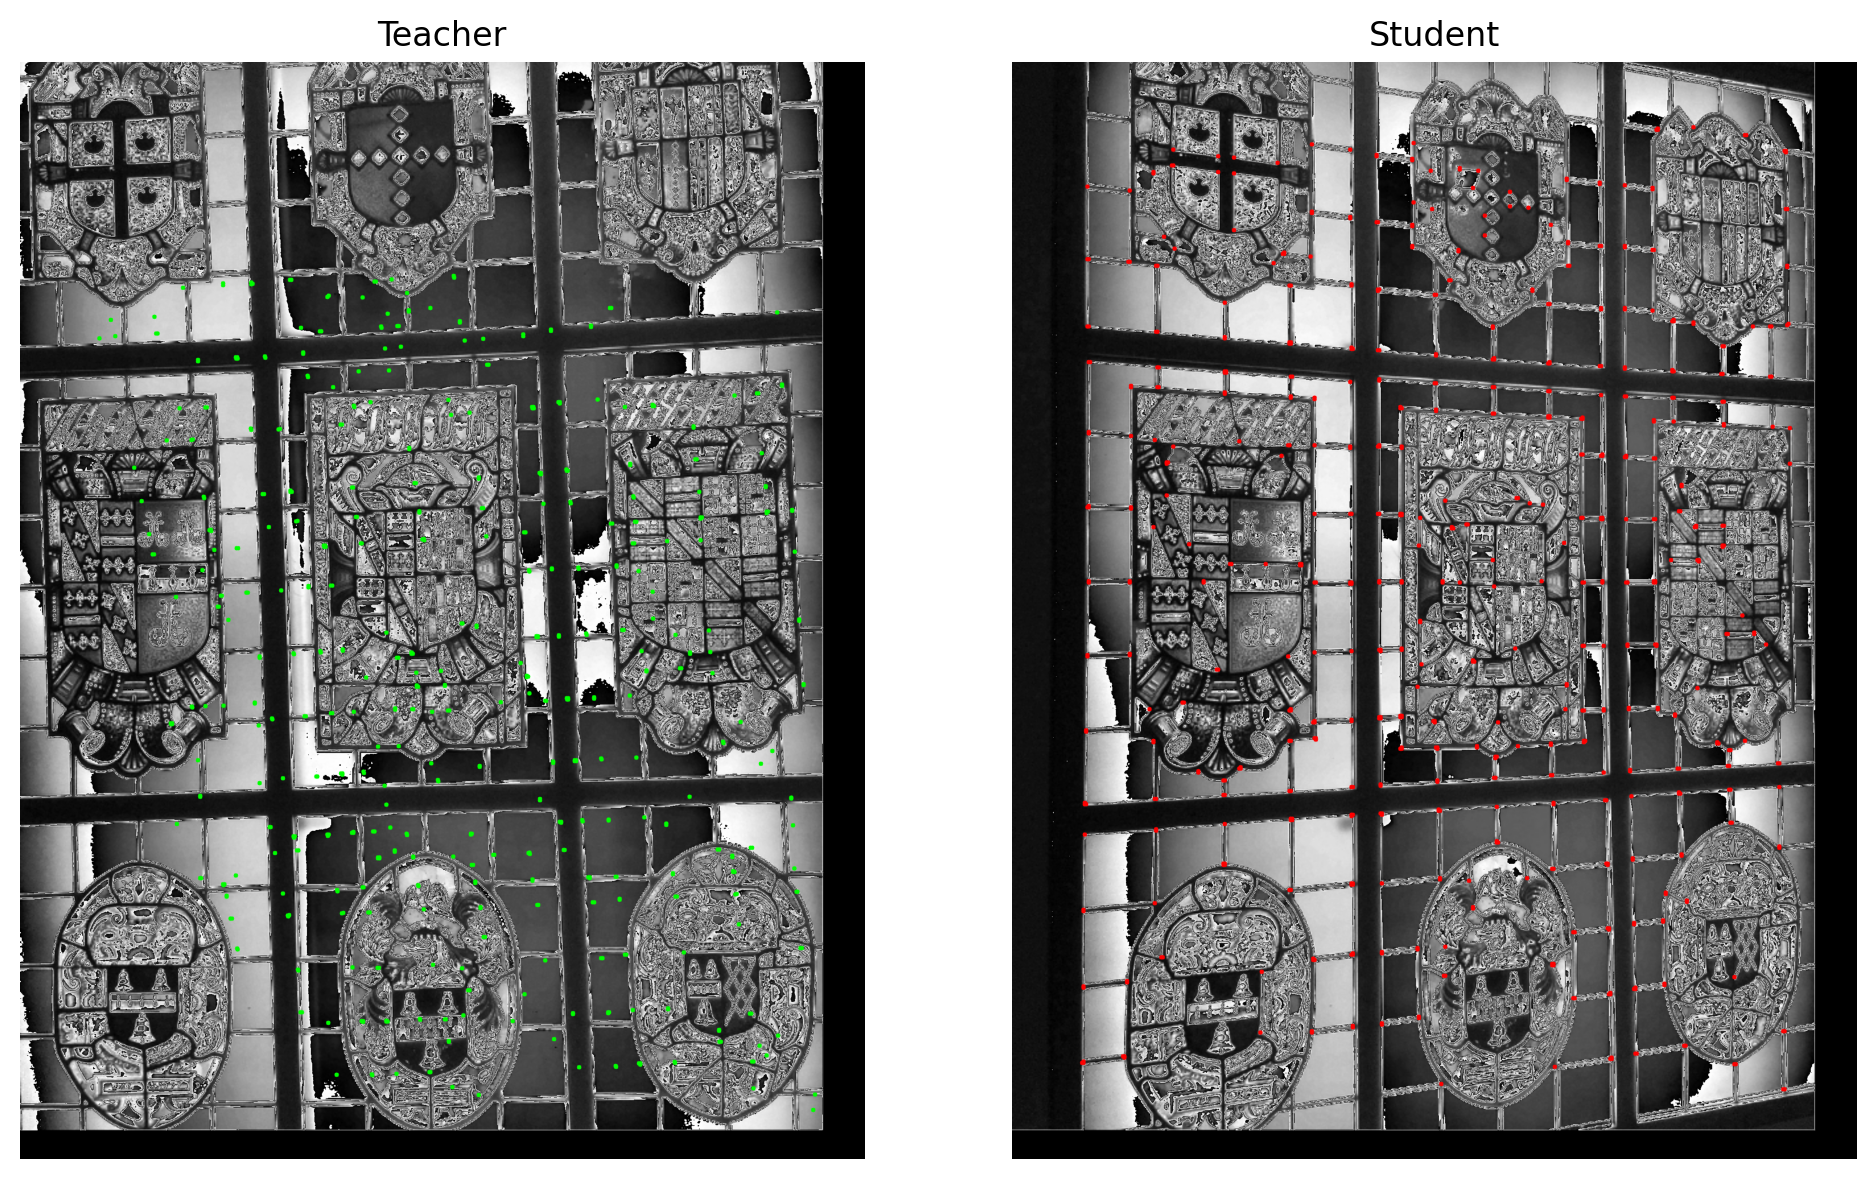

In [33]:
import os
from pathlib import Path
from superpoint_eval_hpatches import compute_repeatability

def save_empty_anno(output_path, img_paths):
    with open(output_path + '/anno.csv', 'w') as csv_file:
        for tile_path in img_paths:
            csv_file.write(tile_path + ',' +
                            ','.join(['', '', '', '']) + ',' + '' + '\n')

classes_path = '/home/baudoin/pytorch-retinanet-pipeline/annotations/visdrone_anno/class_labels.csv'
model_path = '/home/baudoin/pytorch-retinanet-pipeline/results/training_results/20220209-193813/checkpoints/best_model_retinanet_csv.pt'

hpatches_path = '/home/baudoin/data/hpatches-sequences-release/'
scene_paths = [x[0] for x in os.walk(hpatches_path)][1:]

get_superpoint_output(scene_paths, classes_path, model_path)







In [ ]:

for scene_path in scene_paths:
    scene_name = Path(scene_path).stem
    if scene_name[0] == 'v':
        img_1 = scene_path + '/1.ppm'
        img_2 = scene_path + '/2.ppm'
        H_1_2 = scene_path + '/H_1_2.txt'
        save_empty_anno(scene_path, [img_1, img_2])
        pts_student, heatmap_student, pts_teacher, heatmap_teacher = get_superpoint_output(scene_path + '/anno.csv',classes_path, model_path)
        data_keypoints = {}
        data_keypoints['prob'] = pts_teacher.T[:,[1,0,2]]
        data_keypoints['warped_prob'] = pts_student.T[:,[1,0,2]]#select_k_best(pts_student.T[:,[1,0,2]], pts_teacher.shape[1])
        data_keypoints['image'] = img_gray
        data_keypoints['homography'] = np.identity(3)
        repeatability, localization_err = compute_repeatability(data_keypoints, distance_thresh=3, keep_k_points=1000)
    break    